notebook generates rebinned spectra and physical quantities, given specified integration time 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import optimize
from scipy.optimize import curve_fit

import sys
sys.path.append("../")
from create_arrays import siiv

In [2]:
# import arrays
tube = readsav('/Users/WilliamHenryAshfieldIV/dat/ebtel_l85_h150_30min_subI.sav',verbose=False,python_dict=False)
frac = readsav('/Users/WilliamHenryAshfieldIV/dat/nei_files/ebtel_30min_subI_si_iv_nei.sav',verbose=False,python_dict=False)
log10T,log10G = np.loadtxt('/Users/WilliamHenryAshfieldIV/dat/goft_1403.dat.txt',comments='%',unpack=True)

In [3]:
t_n = tube.tarr.shape[0] - 1 # len of tube in time (in steps of 0.1s)
line = 1402.77

../create_arrays.py:70: RuntimeWarning: invalid value encountered in true_divide
  temp_fac = f_nei/f_eqi
../create_arrays.py:130: RuntimeWarning: invalid value encountered in true_divide
  factor = nei/eqi
../create_arrays.py:184: RuntimeWarning: invalid value encountered in sqrt
  meas_error = np.sqrt(tot_emissNEI) # error measured


(1402, 1404)

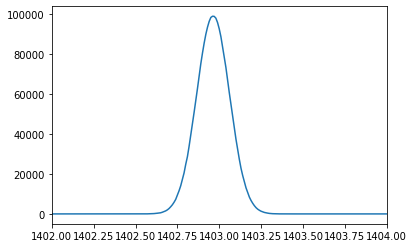

In [4]:
k = 155
arrs = siiv(tube,frac,log10T,log10G,time=k)
plt.plot(arrs.wav,arrs.spec)
plt.xlim(1402,1404)

In [5]:
ll = arrs.wav

In [6]:
arrs.rebin()

reshape index =  25


../create_arrays.py:130: RuntimeWarning: divide by zero encountered in true_divide
  factor = nei/eqi
../create_arrays.py:171: RuntimeWarning: overflow encountered in double_scalars
  emissNEI[i,:] = photo_fac*EM[i]*factor[i]*10**g[i]/np.sqrt(2*np.pi)/sig[i]*np.exp(-(ll-line-line*v[i]/c)**2/(2*sig[i]**2))
../create_arrays.py:171: RuntimeWarning: invalid value encountered in double_scalars
  emissNEI[i,:] = photo_fac*EM[i]*factor[i]*10**g[i]/np.sqrt(2*np.pi)/sig[i]*np.exp(-(ll-line-line*v[i]/c)**2/(2*sig[i]**2))


number of time elements after rebin:  32


Text(0.5, 0, 'wavelength [$\\AA$]')

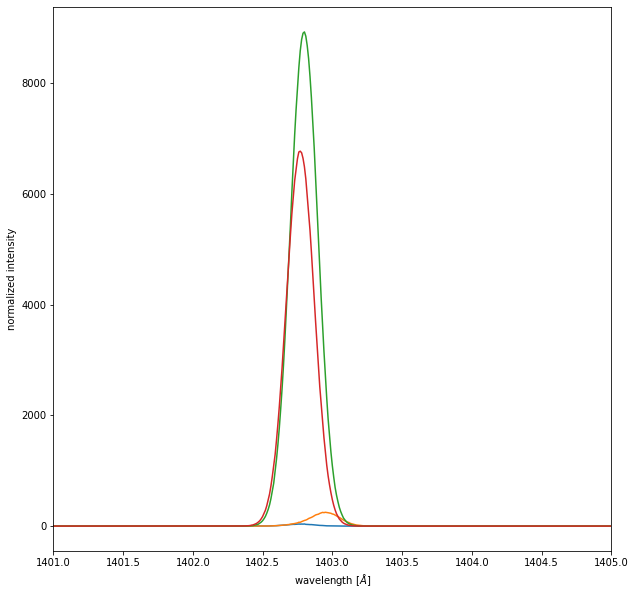

In [7]:
fig, ax = plt.subplots(figsize=[10,10])
plt.plot(ll,arrs.respec[0,:])
plt.plot(ll,arrs.respec[5,:])
plt.plot(ll,arrs.respec[10,:])
plt.plot(ll,arrs.respec[15,:])
plt.xlim(1401,1405)
plt.ylabel('normalized intensity')
ax.set_xlabel('wavelength [$\AA$]')

In [8]:
arrs.respec.shape

(32, 2000)

# Time series of synthetic spectrum:

In [9]:
from create_arrays import siiv

In [10]:
nt = len(arrs.time)-1

In [11]:
err = arrs.reerror[0,:]

In [12]:
dat = arrs.respec[0,:]

In [13]:
arrs.fitspec()

nt =  32
i =  0
time =  0.0
a2g1 =  1402.7701748292125
a2g4 =  1402.7701748292125
i =  1
time =  5.0
a2g1 =  1402.7695655846005
a2g4 =  1402.7695655846005
i =  2
time =  10.0
a2g1 =  1402.7697218619974
a2g4 =  1402.7697218619974
i =  3
time =  15.0
a2g1 =  1402.769845868236
a2g4 =  1402.769845868236
i =  4
time =  20.0
a2g1 =  1402.769347430821
a2g4 =  1402.769347430821
i =  5
time =  25.0
a2g1 =  1402.9444526305201
a2g4 =  1402.9444526305201
i =  6
time =  30.0
a2g1 =  1402.9391018400809
a2g4 =  1402.9391018400809
i =  7
time =  35.0
a2g1 =  1402.8842998220218
a2g4 =  1402.8842998220218
i =  8
time =  40.0
a2g1 =  1402.8407765758557
a2g4 =  1402.8407765758557
i =  9
time =  45.0
a2g1 =  1402.8137355747497
a2g4 =  1402.8137355747497
i =  10
time =  50.0
a2g1 =  1402.7975772462848
a2g4 =  1402.7975772462848
i =  11
time =  55.0
a2g1 =  1402.7870376227306
a2g4 =  1402.7870376227306
i =  12
time =  60.0
a2g1 =  1402.7796774966112
a2g4 =  1402.7796774966112
i =  13
time =  65.0
a2g1 =  140

(0, 45)

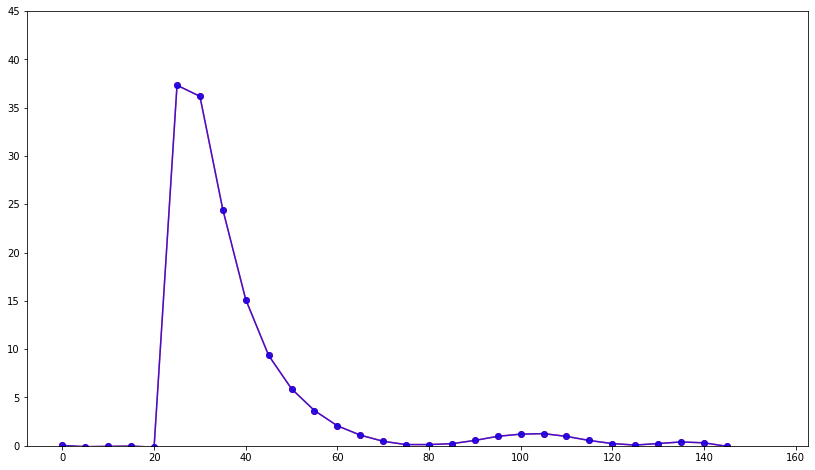

In [19]:
plt.figure(figsize=(14,8))
plt.plot(arrs.time,arrs.vr,'r',alpha=0.75,marker='o')
plt.plot(arrs.time,arrs.vb,'b',alpha=0.75,marker='o')
plt.ylim(0,45)

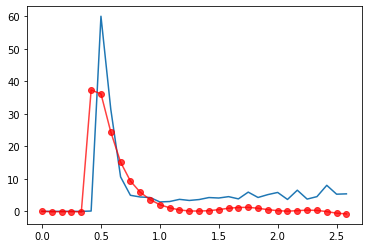

In [20]:
plt.plot(arrs.time/60,arrs.amp/np.max(arrs.amp)*60)
plt.plot(arrs.time/60,arrs.vr,'r',alpha=0.75,marker='o')

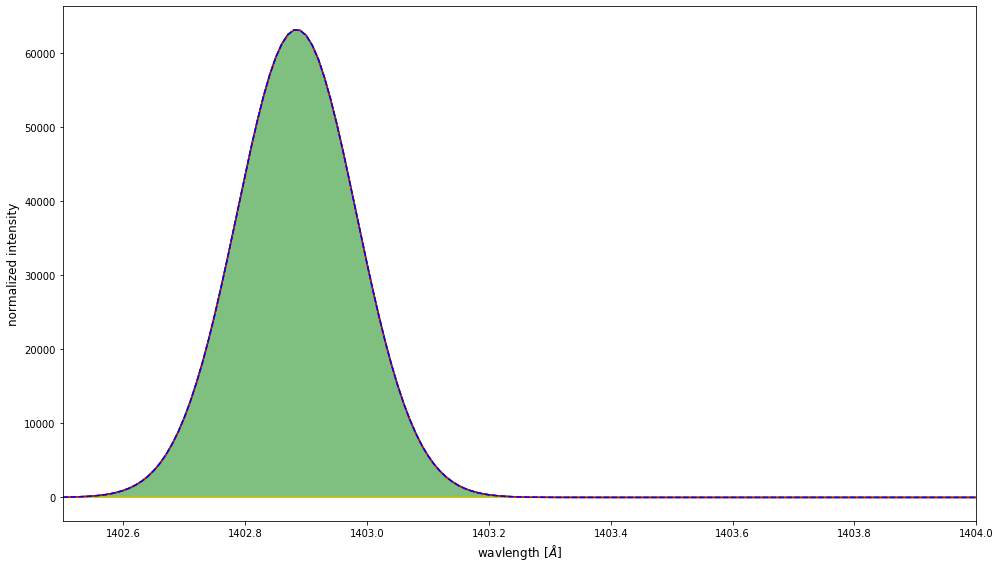

In [23]:
arrs.plotgauss(itime=7)

# Fit:

In [24]:
def u0_fit(t, *a):
    return a[0]/(1+t/a[1])

In [25]:
imax = np.argmax(arrs.vr) 

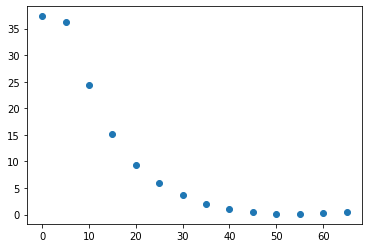

In [37]:
tt = arrs.time[imax:-13]
tt = tt-tt[0]
vr = arrs.vr[imax:-13]
plt.plot(tt,vr,'o')

In [38]:
a0= [55,15]
popt, pcov = curve_fit(u0_fit, tt, vr,p0=a0)

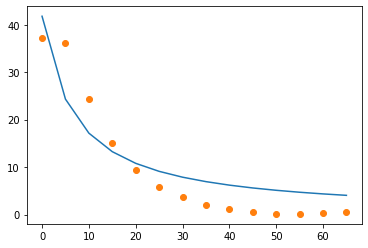

In [39]:
plt.plot(tt,u0_fit(tt,*popt))
plt.plot(tt,vr,'o')

In [40]:
popt[1]

6.959555087497491

In [41]:
H = 0.6*popt[0]*popt[1]

In [42]:
H

174.5201855361527